In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping



import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer



import gensim
from gensim.models import KeyedVectors


# Utility
import re
import os


Using TensorFlow backend.


In [2]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:

TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 10
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 2
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "positive"
NEGATIVE = "negative"
NEUTRAL = "neutral"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [0]:
df= pd.read_csv('/content/drive/My Drive/Projects/Twitter airlines/Tweets.csv')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
list(df['airline_sentiment'].unique())

['neutral', 'positive', 'negative']

In [0]:
stop_words= stopwords.words('english')
stemmer= SnowballStemmer('english')

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
df.text = df.text.apply(lambda x: preprocess(x))

In [9]:
df_train,df_test= train_test_split(df,test_size=1-TRAIN_SIZE,random_state=42)
print('Train size',len(df_train))
print('Test size',len(df_test))

Train size 11712
Test size 2928


In [10]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 10.3 ms, sys: 2.06 ms, total: 12.3 ms
Wall time: 12.1 ms


In [11]:
documents[1]

['jfk',
 'nyc',
 'staff',
 'amazing',
 'lax',
 'jetblue',
 'sending',
 'email',
 'details',
 'disappointing',
 'experience',
 'jetbluecheeps']

In [12]:
df_train['text'].head()

750                     offering us 8 rooms 32 people fail
6875     jfk nyc staff amazing lax jetblue sending emai...
7598     well last update right direction least keep fi...
14124    flight 3056 still sitting dfw waiting baggage ...
6187     companion pass broken today purchase error inv...
Name: text, dtype: object

In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [0]:
w2v_model.build_vocab(documents)

In [15]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1534


In [16]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


(2440817, 3464448)

In [0]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df_train.text)

In [18]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 12198


In [19]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 340 ms, sys: 6.97 ms, total: 347 ms
Wall time: 348 ms


In [20]:
df_train.airline_sentiment.unique().tolist()

['negative', 'positive', 'neutral']

In [21]:
encoder = LabelEncoder()
encoder.fit(df_train.airline_sentiment.tolist())

y_train = encoder.transform(df_train.airline_sentiment.tolist())
y_test = encoder.transform(df_test.airline_sentiment.tolist())


#y_train = y_train.reshape(-1,1)
#y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (11712,)
y_test (2928,)


In [22]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print("y_train",y_train.shape)
print("y_test",y_test.shape)


y_train (11712, 3)
y_test (2928, 3)


In [23]:
tokenizer.word_index

{'flight': 1,
 'get': 2,
 'thanks': 3,
 'cancelled': 4,
 'service': 5,
 '2': 6,
 'help': 7,
 'time': 8,
 'customer': 9,
 'amp': 10,
 'us': 11,
 'hours': 12,
 'hold': 13,
 'flights': 14,
 'plane': 15,
 'thank': 16,
 'please': 17,
 'still': 18,
 'would': 19,
 'one': 20,
 'need': 21,
 'back': 22,
 'delayed': 23,
 'bag': 24,
 'gate': 25,
 'call': 26,
 'flightled': 27,
 'hour': 28,
 'got': 29,
 'united': 30,
 'today': 31,
 'like': 32,
 'phone': 33,
 '3': 34,
 'jetblue': 35,
 'airline': 36,
 'late': 37,
 'fly': 38,
 'guys': 39,
 'know': 40,
 'waiting': 41,
 'airport': 42,
 '1': 43,
 '4': 44,
 'trying': 45,
 'u': 46,
 'way': 47,
 'great': 48,
 'day': 49,
 'change': 50,
 'wait': 51,
 'flying': 52,
 'make': 53,
 'really': 54,
 'never': 55,
 'check': 56,
 'go': 57,
 'weather': 58,
 'going': 59,
 'tomorrow': 60,
 'last': 61,
 'good': 62,
 '5': 63,
 'delay': 64,
 'home': 65,
 'even': 66,
 'minutes': 67,
 'people': 68,
 'seat': 69,
 'dm': 70,
 'w': 71,
 'new': 72,
 'agent': 73,
 'another': 74,
 'wa

In [24]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(12198, 300)


In [25]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [0]:
from keras.layers import Bidirectional

In [27]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
##callbacks
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]


In [29]:
##train
%%time
history = model.fit(x_train, y_train,
                    batch_size=50,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)



Train on 10540 samples, validate on 1172 samples
Epoch 1/5
10540/10540 [==============================] - 196s 19ms/step - loss: 0.4123 - acc: 0.8141 - val_loss: 0.3709 - val_acc: 0.8330
Epoch 2/5
10540/10540 [==============================] - 198s 19ms/step - loss: 0.3694 - acc: 0.8357 - val_loss: 0.3583 - val_acc: 0.8396
Epoch 3/5
10540/10540 [==============================] - 197s 19ms/step - loss: 0.3588 - acc: 0.8387 - val_loss: 0.3517 - val_acc: 0.8387
Epoch 4/5
10540/10540 [==============================] - 192s 18ms/step - loss: 0.3533 - acc: 0.8436 - val_loss: 0.3474 - val_acc: 0.8382
Epoch 5/5
10540/10540 [==============================] - 190s 18ms/step - loss: 0.3456 - acc: 0.8468 - val_loss: 0.3429 - val_acc: 0.8444
CPU times: user 26min 57s, sys: 4min 33s, total: 31min 31s
Wall time: 16min 13s


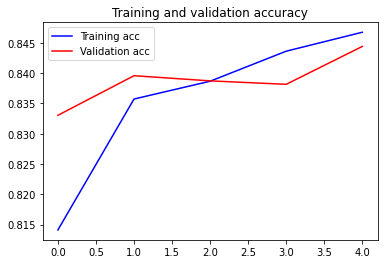

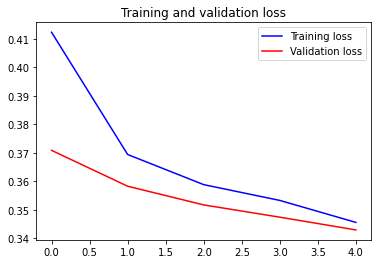

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [0]:
#def decode_sentiment(score,include_neutral=True):
#  if include_neutral:
#    label=NEUTRAL
#    if score <= SENTIMENT_THRESHOLDS[0]:
#      label= NEGATIVE
#    elif score >= SENTIMENT_THRESHOLDS[1]:
#      label= POSITIVE
#    return label


In [0]:
#def predict(text,include_neutral=True):
#  start_at = time.time()
#  # Tokenize text
#  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
#  # Predict
#  score = model.predict([x_test])[0]
#  label = decode_sentiment(score, include_neutral=include_neutral)
#  return {"label": label, "score": float(score),
#       "elapsed_time": time.time()-start_at}  

In [32]:
score = model.predict(x_test,batch_size=20,verbose=1)

2928/2928 [==============================] - 51s 17ms/step


In [0]:
def preprocess(text):
  
  review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',text)
  review=review.lower()
  review=review.split()
  review=[word for word in review if not word in stop_words]
  print(review)
  review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)
  return review

In [0]:
def prediction(review):
    review=preprocess(review)
    score=model.predict(review)
    score=np.argmax(score,axis=1)
    if score<0.4:
        print("Negative")
    elif (score>0.4) & (score<0.6):
        print("Neutral")
    else:
        print("Positive")
    print(score)

In [37]:
prediction('The Food Is Not Bad')

['food', 'bad']
Negative
[0]


In [40]:
prediction("@AmericanAir it's more than technical problems. #frustrated #answerthephone Res. on hold and can't get thru to use a credit to pay for it")

['technical', 'problems', 'frustrated', 'answerthephone', 'res', 'hold', 'get', 'thru', 'use', 'credit', 'pay']
Negative
[0]


In [0]:
len(score)

In [0]:
new=[]
for i in range(len(score)):

  new= np.median(score[i])
  print(new)

In [0]:
len(new)